# The Battle of the Neighborhoods  
###        _Applied Data Science Capstone_ 

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#resultsanddiscussion)
* [Conclusion and Final Remarks](#conclusion)

# Glass Recycling Bins in Lisbon

### <p style="color:red;"> Unfortunately, GitHub does not support the visualization of folium maps. Please, paste the URL of this notebook on https://nbviewer.jupyter.org/ to be able to see the maps. </p>

## Introduction <a name="introduction"></a>

#### Background

If you are ever in Portugal, just finished a great meal and are now drinking an espresso by the riverside, enjoying the beautiful view, all the while you are listening to a beautiful Fado playing from one of the open windows of a house nearby , chances are you are in Lisbon. The capital of Portugal, from where Vasco da Gama set sail to discover the sea route do India on 1497, is a city full of culture, beautiful sites, and nice people. However, not everything in Lisbon is so wonderful. Filled with restaurants, pubs, and nightclubs, the city streets close to the venues are quick to fill with trash, especially on the weekends. This issue is particularly concerning for those who experience the nightlife, where a broken bottle on the ground could spell disaster for anyone who has had a few drinks too many that evening. Unfortunately, waste management in certain areas of Lisbon is still an issue, and even though the Municipality has implemented some measures to reduce the piling up of broken bottles near full bins, not much has been solved. Popular places like Bairro Alto, Cais do Sodré, Terreiro do Paço, are as filled with trash by Saturday and Sunday morning as their bars were full of costumers the night before. If one wants to see where the best pubs are, just follow the trail of broken bottles.

#### The Problem

In the present report, I imagined the Lisbon Municipality wanted to implement a better waste management plan, particularly concerning the disposal of glass residues. For that, the stakeholders need to understand which areas have a high density of venues related to the production of glass residues (Bars, Restaurants, etc.), and which are lacking glass recycling bins (GRBs). Although any local resident can pinpoint a lot of candidate places for intervention, let us imagine for the sake of this study that the Municipality only has the budget for a limited number of GRBs. In that case, they need to understand which areas are most severely affected by this problem and invest their efforts and resources accordingly. Therefore, on this report I will present the analysis I used to identify the areas in need of more urgent action concerning the installation of GRBs. This will include the data analysis and leverage of the Foursquare Places API and the knowledge obtained in the various courses of the IBM Data Science Professional Certificate.

## Data <a name="data"></a>

Before starting to address the problem, it is necessary to collect and prepare the data. The required data is pertaining to both GRBs and relevant venues in Lisbon, particularly geospatial information about individual datapoints. 

Let's start by importing the necessary Libraries

In [1]:
import numpy as np

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import json 

from geopy.geocoders import Nominatim

import requests 
from pandas.io.json import json_normalize

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

#!pip install folium
import folium
from folium import plugins
from folium.plugins import HeatMap

import requests
from bs4 import BeautifulSoup

#!pip install shapely
import shapely.geometry

#!pip install pyproj
import pyproj
from pyproj import Transformer

import math


print('Libraries imported.')

Libraries imported.


### Glass Recycling Bin data collection

I will use the data for <b>Glass Recycling Bin</b> (GRB) locations provided by the Municipality of Lisbon at http://geodados.cm-lisboa.pt/datasets/vidr%C3%B5es/data. However, instead of scraping the existing table, I will use the .csv file that is availabe for download, since it provides the coordinates for each individual bin. Let's place this data in a <i>pandas</i> dataframe and check it's size.

In [2]:
grb = pd.read_csv("https://opendata.arcgis.com/datasets/e4af86f9aabe44a1a036a2c677f2755b_5.csv")
print("There are {} glass recycling bins in Lisbon.".format(grb.shape[0]))
grb.head()

There are 849 glass recycling bins in Lisbon.


,X,Y,OBJECTID,COD_SIG,IDTIPO,TPRS_DESC,FRE_AB,TOP_MOD_1,PRSL_LOCAL,PRODUTOR,GlobalID
0,-9.131430,38.745780,1,8473,9116,Vidrão,Areeiro,Avenida Almirante Gago Coutinho,Jt 37,n.a.,dcd58659-facb-444b-acb1-db5f6c53a4fb
1,-9.186607,38.756752,2,7361,9116,Vidrão,Carnide,Rua Ana Castro Osorio,Próximo nº 10,n.a.,524a7425-bd18-4f84-a8a4-20339c482465
2,-9.188336,38.757791,3,7370,9116,Vidrão,Carnide,Rua Maria Brown,Próximo ao nº 7,n.a.,39a7539c-778e-4eee-a9d3-fa71eca0d342
3,-9.165865,38.769504,4,8716,9116,Vidrão,Lumiar,Rua Francisco Conceicao Silva,Ft 5 (Alta da Faia III),n.a.,f4595043-0ed3-4e77-8303-e8a01592363a
4,-9.201951,38.745813,5,7387,9116,Vidrão,Benfica,Rua Parque,Crzt R Actor Estevão Amarante,n.a.,3a631ad4-5f16-4b2f-978b-f859c83740f7


Now, let's keep only the 'X' and 'Y' columns and rename them 'Longitude' and 'Latitude', respectively. Lets  also set the Latitude as the first column, for simplicity.

In [3]:
grb = grb[["Y","X"]]
grb.columns = ['Latitude','Longitude']

grb.head()

,Latitude,Longitude
0,38.745780,-9.131430
1,38.756752,-9.186607
2,38.757791,-9.188336
3,38.769504,-9.165865
4,38.745813,-9.201951


Now that we have the coordinates of all GRBs in Lisbon, let's define our area of assessment. For that, we will use the coordinates for the Marquis of Pombal Square (MPS) as the center of our map. Although it is not the official city centre, the Marquis of Pombal Square is one of the most iconic (and busiest) roundabouts in Lisbon. The distance from this square to the margin of the River Tagus is of approximately 2.5km, so let's define our study area using this measurement as the radius of a circle centered on the MPS. Let's plot this area on the map, as well as the GRB data we have so far:

In [4]:
#coordinates for the Marquis of Pombal Square
MPS_lat = 38.72545
MPS_long = -9.14990
radius = 2500

lisbon_map = folium.Map(location=[MPS_lat, MPS_long], zoom_start=14)

#adding markers to the bins
for lat, lng, in zip(grb['Latitude'], grb['Longitude']):
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        fill=True,
        fill_color='#32CD32',
        fill_opacity=0.7,
        parse_html=False).add_to(lisbon_map)

        
folium.Circle(location=[MPS_lat, MPS_long], radius=2500, color='blue', fill=False).add_to(lisbon_map)

#for lat, lon in zip(circles['Latitude'], circles['Longitude']):
#    folium.Circle([lat, lon], radius=284, color='#000000', fill=False).add_to(lisbon_map)
        
lisbon_map

### Venue data collection

Now we can easily visualize our study area, as well as all the GRBs in Lisbon. We will not exclude the ones located outside our circunference just yet. Instead, let's collect the data pertaining to <b>venues</b> located inside our study area, using the Foursquare API. However, there is a problem: the API returns 100 venues per call, which is not nearly enough for us to satisfactory populate our map. So, to bypass this problem, we will define a subset of coordinates inside our study area and make individual requests for each of those coordinates. Since the Fourquare API returns a list of venues around a specific radius around a given coordinate, we will divide the study area in a collection of circles. For that, we will borrow three functions from the example notebook in this week's material so we can easily toggle between coordinate formats (lonlat vs xy) to create a subset of circles of approximatly 0.25 km<sup>2</sup>.

In [5]:
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

Let's define the center of each circle and assign it to a database, using the following code:

In [6]:
lisbon_center_x, lisbon_center_y = lonlat_to_xy(MPS_long, MPS_lat) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = lisbon_center_x - 6000
x_step = 600
y_min = lisbon_center_y - 6000 - (int(21/k)*k*600 - 12000)/2
y_step = 600 * k 


latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(lisbon_center_x, lisbon_center_y, x, y)
        if (distance_from_center <= 2500): # this retricts our coordinates to the inside of the big circunference
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

s_circles_dict = {}  
            
for lat, lon in zip(latitudes, longitudes):
    s_circles_dict[lat] = [lon]

circles = pd.DataFrame.from_dict(s_circles_dict, orient='index').reset_index()
circles.columns = ['Latitude','Longitude']

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:10: DeprecationWarning: This function 

In [7]:
circles.reset_index(inplace=True)
circles.head()

,index,Latitude,Longitude
0,0,38.706287,-9.153224
1,1,38.707671,-9.146929
2,2,38.709054,-9.140633
3,3,38.710437,-9.134337
4,4,38.708482,-9.164197


Let's add these circles to our map, so we can visualize the area each API call will cover

In [8]:
for lat, lon in zip(circles['Latitude'], circles['Longitude']):
    folium.Circle([lat, lon], radius=284, color='#000000', fill=False).add_to(lisbon_map)
        
lisbon_map

We are now ready to use the Foursquare API to get the venue data. I will insert my credential in the hidden cell bellow.

In [9]:
# @hidden_cell

Let's use the function from the Week 3 Lab and call it to get the top 100 venues located inside each circle and assign the result to the lisbon_venues database

In [10]:
LIMIT = 100 # limit of number of venues to 100

radius = 284 # 284m radius 

def getNearbyVenues(names, latitudes, longitudes, radius=284):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['circle', 
                  'circle Latitude', 
                  'circle Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
lisbon_venues = getNearbyVenues(names=circles['index'],
                                   latitudes=circles['Latitude'],
                                   longitudes=circles['Longitude']
                                  )
print('done!')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
done!


Now we can see what our database lisbon_venues looks like

In [12]:
lisbon_venues.head()

,circle,circle Latitude,circle Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,38.706287,-9.153224,Jazzy Dance Studios,38.706059,-9.152459,Dance Studio
1,0,38.706287,-9.153224,Davvero Gelato,38.707399,-9.152619,Ice Cream Shop
2,0,38.706287,-9.153224,Local - Your Healthy Kitchen,38.706783,-9.153396,Vegetarian / Vegan Restaurant
3,0,38.706287,-9.153224,Academia Life Club,38.705725,-9.153241,Gym
4,0,38.706287,-9.153224,Wanli,38.707882,-9.154795,Lounge


Indeed, Foursquare was able to provide us with the data we requested. However, we can see that some Venues are not normaly associated with producing great amounts of glass waste. In order to proceed with our analysis, we want to keep venues that fall into the category of Restaurant, Café, Bar, Pub. First let's create a list with all unique venue categories.

In [13]:
lisbon_venues.rename(columns={'Venue Category':'Venue_Category'}, inplace=True) #renaming the column to remove the space, so we can call it's name on the next line
unique_venue_category = lisbon_venues.Venue_Category.unique()

We can check if any of the unique venue categories contains the names Restaurant, Café, Bar, or Pub, and restrict our dataframe accordingly.

In [14]:
filt = []

for item in unique_venue_category:
    a = str(item)
    if 'Restaurant' in a or 'Café' in a or 'Pub' in a or 'Bar' in a or 'Bodega' in a:
        filt.append(a)

lisbon_vf = lisbon_venues.loc[lisbon_venues['Venue_Category'].isin(filt)] #formerly l2 #short for lisbon_venues_filtered
print(str(lisbon_vf.shape[0]) + " venues remaining.")
lisbon_vf.head()

627 venues remaining.


,circle,circle Latitude,circle Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category
2,0,38.706287,-9.153224,Local - Your Healthy Kitchen,38.706783,-9.153396,Vegetarian / Vegan Restaurant
5,0,38.706287,-9.153224,Marco,38.707091,-9.154383,Portuguese Restaurant
6,0,38.706287,-9.153224,Lizboa Café,38.707828,-9.153279,Portuguese Restaurant
7,0,38.706287,-9.153224,Frade dos Mares,38.708559,-9.152991,Seafood Restaurant
8,0,38.706287,-9.153224,Petiscaria Ideal,38.708140,-9.154802,Portuguese Restaurant


We can visualize these venues in a new Lisbon map

In [15]:
lisbon_map_2 = folium.Map(location=[MPS_lat, MPS_long], zoom_start=14)

#adding markers to the bins
for lat, lng, in zip(grb['Latitude'], grb['Longitude']):
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        fill=True,
        fill_color='#32CD32',
        fill_opacity=0.7,
        parse_html=False).add_to(lisbon_map) 

        
folium.Circle(location=[MPS_lat, MPS_long], radius=2500, color='blue', fill=False).add_to(lisbon_map_2)

for lat, lng, in zip(lisbon_vf['Venue Latitude'], lisbon_vf['Venue Longitude']):
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        fill=True,
        fill_color=' #1E90FF',
        fill_opacity=0.7,
        parse_html=False).add_to(lisbon_map_2) 
        
lisbon_map_2

Let's write some code to limit the GRBs in our analysis to the ones located inside the circles, and assign them to a new dataframe, grb_2

In [16]:
grb_2_dict = {}

for lat_grb, lon_grb in zip(grb['Latitude'],grb['Longitude']):
    distance = []
    for lat_c, lon_c in zip (circles['Latitude'],circles['Longitude']):
        
        d = calc_xy_distance(lon_grb, lat_grb, lon_c, lat_c)
        distance.append(d)
 
    if min(distance) < 0.00284: # if the distance between the GRB and one of the circle centers is less than 284m we keep the bin in our analysis and assign it to the grb_2_dict
            grb_2_dict[lat_grb] = lon_grb
            

grb_2 = pd.DataFrame.from_dict(grb_2_dict, orient='index').reset_index() #creating a new dataframe from the grb_2_dict dictionary
grb_2.columns = ['Latitude','Longitude']
print('We have {} glass recycling bins in our assessment area.'.format(grb_2.shape[0]))
grb_2.head()

We have 194 glass recycling bins in our assessment area.


,Latitude,Longitude
0,38.735256,-9.147349
1,38.727358,-9.146145
2,38.729666,-9.150099
3,38.719661,-9.155959
4,38.723969,-9.148443


To finish this section, let's plot the restricted GRB data in our new map, together with the relevant venues, so we can have a good geospacial sense of our data

In [17]:
for lat, lng, in zip(grb_2['Latitude'], grb_2['Longitude']):
        folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='green',
        fill=True,
        fill_color='#32CD32',
        fill_opacity=0.7,
        parse_html=False).add_to(lisbon_map_2) 

lisbon_map_2

This concludes the *Data* section. To summarize, we have:
 <ul>
  <li>defined and delimited our study area</li>
  <li>created a subset of circles inside this area to facilitate our Foursquare request, and stored the coordinates in the the circles dataframe</li>
  <li>collected GRB location data in the grb_2 dataframe</li>
  <li>collected Venue location in the lisbon_vf dataframe</li></ul> 

## Methodology <a name="methodology"></a>

Having collected the data, we can get a sense that there are areas where the density of GRBs is higher than other. Likewise, we can observe a very high density of venues in some areas, while lower on others. Let's start by visualize the densities of GRBs on a Heatmap. We will need to add the column 'count' to our grb_2 database, with the value set to 1 in every row. Instead of adding it directly, let's create a copy of the database, and make the alteration there

In [18]:
grb_3 = grb_2.copy()
grb_3['count'] = 1

In [19]:
grb_heat = folium.Map(location=[MPS_lat, MPS_long], zoom_start=14)
#folium.TileLayer('cartodbpositron').add_to(lisbon_heat) #cartodbpositron cartodbdark_matter

HeatMap(data = grb_3[['Latitude', 'Longitude','count']].groupby(['Latitude', 'Longitude']).sum().reset_index().values.tolist(), radius=30, zoom_start=12).add_to(grb_heat)

folium.Circle(location=[MPS_lat, MPS_long], radius=2500, fill=False, color='blue').add_to(grb_heat)


grb_heat

We can see that the southern area of Lisbon is rather thin on GRBs. But how does that correlate with the number of venues in the area? Before we proceed with the venue density visualization, let's go back to our subset of circles. We can check how many GRBs are inside each circle and plot this information on a histogram. Let's first count the GRBs per circle using the following code and put this information in a copy of the circles dataframe:

In [20]:
grb_count = [] #this empty list will save the counts for each row in our circles dataframe

for lat_c, lon_c in zip(circles['Latitude'],circles['Longitude']):
    i = 0 #i variable will store the count of GRBs in a circle
    for lat_grb_2, lon_grb_2 in zip(grb_2['Latitude'],grb_2['Longitude']):
        dstc = calc_xy_distance(lon_grb_2, lat_grb_2, lon_c, lat_c)
        
        if (dstc) <= 0.00284: #if the distance between the center of the circle and a given GRB is less than its radius, then we can say the former contais the latter, and so we add it to the count
            i = i+1 
    grb_count.append(i) #before finishing the loop, we add i to the grb_count list
        

circles_2 = circles.copy()
circles_2['grb_count'] = grb_count #we assign the list to a new column named 'grb_count' in a copy of our circles dataframe
circles_2.head()

,index,Latitude,Longitude,grb_count
0,0,38.706287,-9.153224,1
1,1,38.707671,-9.146929,1
2,2,38.709054,-9.140633,1
3,3,38.710437,-9.134337,0
4,4,38.708482,-9.164197,0


And now we can plot the histogram

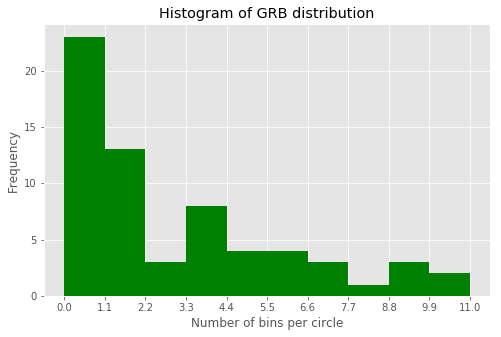

In [21]:
mpl.style.use('ggplot')

count, bin_edges = np.histogram(circles_2['grb_count'])

circles_2['grb_count'].plot(kind='hist', color ='green' ,figsize=(8,5), xticks=bin_edges)

plt.title('Histogram of GRB distribution')
plt.xlabel('Number of bins per circle')
plt.ylabel('Frequency')

plt.show()

It would also be interesting to see the number of venues per circle. Let's first count the number of venues per circle using the .count() function and then we can plot the histogram

In [22]:
lisbon_vf_count = lisbon_vf.groupby('circle').count()[['Venue']].reset_index()
lisbon_vf_count.rename(columns={'circle':'index'}, inplace=True)
lisbon_vf_count.rename(columns={'Venue':'v_count'}, inplace=True)
print("We have {} circles without any venues. We will discard them from our analysis and proceed with the remaining {}".format(circles_2.shape[0]-lisbon_vf_count.shape[0],lisbon_vf_count.shape[0]))

We have 9 circles without any venues. We will discard them from our analysis and proceed with the remaining 55


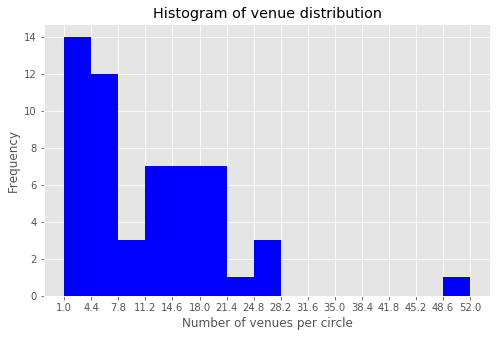

In [23]:
mpl.style.use('ggplot')

count, bin_edges = np.histogram(lisbon_vf_count['v_count'], bins=15)

lisbon_vf_count['v_count'].plot(kind='hist', bins=15, color = 'blue', figsize=(8,5), xticks=bin_edges)

plt.title('Histogram of venue distribution')
plt.xlabel('Number of venues per circle')
plt.ylabel('Frequency')

plt.show()

By analysing the histogram we can see that some while most circles have a low to moderate density of venues, other have an extremely high number. If we inspect the previous maps, we see that some of these areas are located on the South of Lisbon, were there is a lack of GRBs. Let's explore the data some more in each circle and calculate the GRB/Venue ratio

In [24]:
circle_info = pd.merge(circles_2,lisbon_vf_count,on='index')
circle_info.rename(columns={'index':'circle'}, inplace=True)
circle_info['ratio'] = circle_info['grb_count']/circle_info['v_count']
circle_info.head()

,circle,Latitude,Longitude,grb_count,v_count,ratio
0,0,38.706287,-9.153224,1,6,0.166667
1,1,38.707671,-9.146929,1,52,0.019231
2,2,38.709054,-9.140633,1,8,0.125000
3,3,38.710437,-9.134337,0,26,0.000000
4,4,38.708482,-9.164197,0,2,0.000000


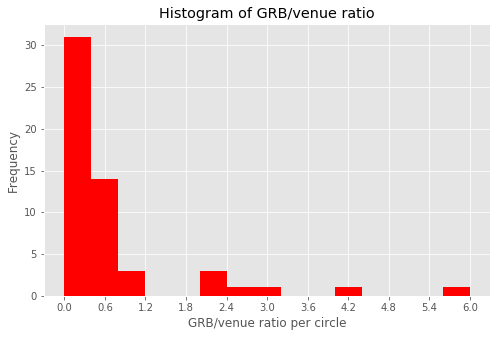

In [25]:
mpl.style.use('ggplot')

count, bin_edges = np.histogram(circle_info['ratio'], bins = 10)

circle_info['ratio'].plot(kind='hist', bins = 15, color = 'red', figsize=(8,5), xticks=bin_edges)

plt.title('Histogram of GRB/venue ratio')
plt.xlabel('GRB/venue ratio per circle')
plt.ylabel('Frequency')

plt.show()

Interestingly, we can see that there is a great number of circles with a low ratio of GRBs/venue, implying that in some places the provided amount of GRBs may not suffice to collect the glass residues generated by the venus. From the inspection of the previous maps, it's natural to suspect these areas are located in the South region. Let's plot the ratio information on a map, using the circles and a color gradient from red to white (red areas have a low GRB/venue ratio while white areas have a high ratio)

In [26]:
limits = np.linspace(circle_info['ratio'].min(),circle_info['ratio'].max(),100)

from colour import Color

colors = list(Color('red').range_to(Color("white"),10))

colors2 = []

for color in colors:
    color = str(color)
    color = color.replace('<Color',"")
    color = color.replace('>',"")
    colors2.append(color)


lisbon_map_3 = folium.Map(location=[MPS_lat, MPS_long], zoom_start=14)

folium.Circle(location=[MPS_lat, MPS_long], radius=2500, fill=False, color='blue').add_to(lisbon_map_3)


for lat, lon, ratio in zip(circle_info['Latitude'], circle_info['Longitude'],circle_info['ratio']):
    
    if ratio == 0:
        color = colors2[0]
    elif ratio < limits[1]:
        color= colors2[1]
    elif ratio < limits[2]:
        color=colors2[2]
    elif ratio < limits[3]:
        color=colors2[3]
    elif ratio < limits[4]:
        color=colors2[4]
    elif ratio < limits[5]:
        color=colors2[5]
    elif ratio < limits[6]:
        color=colors2[6]
    elif ratio < limits[7]:
        color=colors2[7]
    elif ratio < limits[8]:
        color=colors2[8]
    else:
        color=colors2[9] #above limits[8] the ratio is greater than 0.5, meaning more than 1 GRB for 2 venues. Let's set this as our threshold and anything above this can be set as 'white'

        

        
    folium.Circle([lat, lon], radius=284, color='black', fill=True,fill_color = color, fill_opacity=1,parse_html=False).add_to(lisbon_map_3)
        
lisbon_map_3

Indeed, as suspected, the areas with a low GRB/venue ratio are located in the South part of Lisbon. While the previous map enables us to geospatially vizualize the data in the latter histogram, it is only an approximation of the real scenario, as the distribution of GRBs and venues is not uniform in the whole circle area. To have a better understanding of the distribution of GRBs and venue density, we will plot the bin location on top of a venue heatmap, as follows

In [27]:
lisbon_vf_2 = lisbon_vf.copy()
lisbon_vf_2['count']=1

venue_heat = folium.Map(location=[MPS_lat, MPS_long], zoom_start=14)
#folium.TileLayer('cartodbpositron').add_to(lisbon_heat) #cartodbpositron cartodbdark_matter

for lat, lng, in zip(grb_2['Latitude'], grb_2['Longitude']):
        folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=1,
        parse_html=False).add_to(venue_heat)
                                 
HeatMap(data = lisbon_vf_2[['Venue Latitude', 'Venue Longitude','count']].groupby(['Venue Latitude', 'Venue Longitude']).sum().reset_index().values.tolist(), radius=27, zoom_start=12).add_to(venue_heat)

#folium.Marker(location=[MPS_lat, MPS_long]).add_to(lisbon_heat)
folium.Circle(location=[MPS_lat, MPS_long], radius=2500, fill=False, color='blue').add_to(venue_heat)

venue_heat

Now, this map gives us a much clearer view of the GRB distribution across the venue density. We can see the South zone is indeed lacking enough GRBs to be able to respond to the glass residues produced by the local venues. It would be interesting to assign the bars to different clusters and assesst the GRB/venue inside them. Let's define the clusters and delimit a 500 m radius around their central coordinates.

In [28]:
from sklearn.cluster import KMeans

k = 12

clusters_xy_coords =  lisbon_vf[['Venue Longitude', 'Venue Latitude']].values
kmeans = KMeans(k, random_state=0).fit(clusters_xy_coords)

cluster_centers = [(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

cluster_radius = 500

for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=cluster_radius, color='white').add_to(venue_heat) 
    #folium.Marker([lat, lon]).add_to(venue_heat)


venue_heat

We can now count the number of GRBs and venues inside each cluster and calculate their ratio. By doing this, we can have a perception of the ammount of GRBs per venue and define possible areas for intervention. But firsts, we must create a new dataframe to compile all this information. We can store the cluster coordinates, GRB and venue counts, as well as their ratio in individual lists and them work from there:

In [29]:
cluster_number = []
cluster_lat = []
cluster_lon = []
cluster_grb = []
cluster_ven = []
cluster_ratio = []


for lon_k, lat_k in cluster_centers:
    g = 0
    v = 0
    
    for lat_grb, lon_grb in zip(grb_2['Latitude'],grb_2['Longitude']):
        d1 = calc_xy_distance(lon_grb, lat_grb, lon_k, lat_k)
        if d1 < 0.00500:
            g = g+1
    for lat_ven, lon_ven in zip(lisbon_vf['Venue Latitude'],lisbon_vf['Venue Longitude']):
        d2 = calc_xy_distance(lon_ven, lat_ven, lon_k, lat_k)
        if d2 < 0.00500:
            v = v+1    
        
    r = round(g/v,3)
        
     
    
    cluster_lat.append(lat_k)
    cluster_lon.append(lon_k)
    cluster_grb.append(g)
    cluster_ven.append(v)
    cluster_ratio.append(r)
    
for e, rat in enumerate(cluster_ratio):
    cluster_number.append(e)   

print(cluster_number)
print(cluster_lat)     
print(cluster_lon)     
print(cluster_grb)  
print(cluster_ven) 
print(cluster_ratio)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[38.712705600085265, 38.73302877192083, 38.709822660922185, 38.71918378151998, 38.73481886902933, 38.72273726354357, 38.72131220436953, 38.73707337908422, 38.742273414760824, 38.721004886928135, 38.71018845913867, 38.736280025479616]
[-9.135395314614714, -9.143947985484163, -9.146072345277183, -9.163822385740641, -9.133978576933163, -9.15473567711428, -9.145484426620305, -9.164956178317734, -9.146349583063783, -9.13158622938726, -9.157193205580391, -9.15335376509343]
[1, 20, 4, 16, 10, 17, 11, 8, 21, 1, 3, 15]
[59, 57, 88, 44, 32, 41, 52, 16, 38, 25, 24, 44]
[0.017, 0.351, 0.045, 0.364, 0.312, 0.415, 0.212, 0.5, 0.553, 0.04, 0.125, 0.341]


We can now assign the previous lists to a new dataframe, cluster_info.

In [30]:
cluster_i = {}

cluster_i['cluster'] = cluster_number
cluster_i['latitude'] = cluster_lat
cluster_i['longitude'] = cluster_lon
cluster_i['grb'] = cluster_grb
cluster_i['venue'] = cluster_ven
cluster_i['ratio'] = cluster_ratio

cluster_info = pd.DataFrame.from_dict(cluster_i)
cluster_info.sort_values(by=['ratio'])

,cluster,latitude,longitude,grb,venue,ratio
0,0,38.712706,-9.135395,1,59,0.017
9,9,38.721005,-9.131586,1,25,0.040
2,2,38.709823,-9.146072,4,88,0.045
10,10,38.710188,-9.157193,3,24,0.125
6,6,38.721312,-9.145484,11,52,0.212
4,4,38.734819,-9.133979,10,32,0.312
11,11,38.736280,-9.153354,15,44,0.341
1,1,38.733029,-9.143948,20,57,0.351
3,3,38.719184,-9.163822,16,44,0.364
5,5,38.722737,-9.154736,17,41,0.415


Let's set a restriction to clusters that have less than 1 GRB for 10 venues (i.e., ratio < 0.1) and assign the entries to a new dataframe, relevant_clusters...

In [31]:
relevant_clusters = cluster_info[cluster_info['ratio']<0.1]
relevant_clusters

,cluster,latitude,longitude,grb,venue,ratio
0,0,38.712706,-9.135395,1,59,0.017
2,2,38.709823,-9.146072,4,88,0.045
9,9,38.721005,-9.131586,1,25,0.040


... and plot them on the map.

In [32]:
intervention_heat = folium.Map(location=[MPS_lat, MPS_long], zoom_start=14)
#folium.TileLayer('cartodbpositron').add_to(lisbon_heat) #cartodbpositron cartodbdark_matter

for lat, lng, in zip(grb_2['Latitude'], grb_2['Longitude']):
        folium.CircleMarker(
        [lat, lng],
        radius=3,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=1,
        parse_html=False).add_to(intervention_heat)
                                 
HeatMap(data = lisbon_vf_2[['Venue Latitude', 'Venue Longitude','count']].groupby(['Venue Latitude', 'Venue Longitude']).sum().reset_index().values.tolist(), radius=27, zoom_start=12).add_to(intervention_heat)

#folium.Marker(location=[MPS_lat, MPS_long]).add_to(lisbon_heat)
folium.Circle(location=[MPS_lat, MPS_long], radius=2500, fill=False, color='blue').add_to(intervention_heat)

cluster_radius = 500

for lat, lon in zip(relevant_clusters['latitude'],relevant_clusters['longitude']):
    folium.Circle([lat, lon], radius=cluster_radius, color='red').add_to(intervention_heat) 
    folium.Marker([lat, lon],popup=(str(round(lat,4)) + 'N, ' + str(round(-lon,4)) + 'W')).add_to(intervention_heat)

intervention_heat

## Results and Discussion <a name="resultsanddiscussion"></a>

<p> It is pertinent to wonder why I did not take that one last step in the analysis and used an API (e.g., the Google Maps API) to retrieve the addresses of the clusters identified by the K-means clustering method. That would, in fact, be appropriate if the resulting addresses were representative of the cluster, which is not true in this case, as it would retrieve the street names where the center point of each cluster is located. However, the general areas delimited by the clusters are referent to well-known areas in Lisbon, which unfortunately are not officially delimited geographically and, as such, an API call would be unable to retrieve the appropriate designation. But, as any local will be able to tell you, these areas are, from South to East, Cais do Sodré – Bairro Alto, Terreiro do Paço – Mouraria, and Intendente. The first area is well-known for its bars and nightlife, resulting in an extremely high number of venues for the four GRBs available in the vicinities. The second is a famous tourist spot, with lots of restaurants and cafés, whilst only having a single GRB available to receive the glass waste of all these venues. Lastly, the eastmost area, while having roughly half of the number of venues as the previous one, also contains only one GRB, leading to the observed low ratio. </p>
<p>	The identified areas are coincident with those where residents have previously complained about the piles of broken bottles scattered through the streets, due to the lack of available bins for proper disposal. See, for example, <a href="https://www.dn.pt/cidades/reportagem-moradores-queixam-se-do-lixo-em-lisboa-e-pedem-coimas-para-os-infratores--9812531.html">this news article</a> where residents of the Cais do Sodré – Bairro Alto area complain about the amount of garbage that piles up next to the bins. Although the article is written in Portuguese, you can read it using Google translate if you do not understand the language. Also, please note the GRB in the head image of the article, with garbage piling up next to it, including visible glass bottles. Articles like to this one give strength to the presented results and, more importantly, convey them a proper meaning by serving as an illustrative example.</p>

## Conclusion and Final Remarks <a name="conclusion"></a>

The present analysis and results allowed me to properly identify areas in need of urgent intervention by the Lisbon Municipality. To summarize, it is imperative to increase the number of GRBs in the Southern region of Lisbon, in order to adequately respond to the overwhelming amount of glass residues generated in these regions. Nevertheless, it is also important to note that this analysis used the presence of specific venues as a proxy of the glass residues produced in an area. This was because data related to the type and amount of residues produced in a given area was not available, and may not be linearly correlated with the number of venues. For example, an area with no bars or restaurants but that is known to have a lot of resident students may also have an associated production of high quantities of glass residues (in Portugal, beer bottles are relatively more available than beer cans). However, to have this type of information one would require a more complex dataset than the one available though Foursquare or other free APIs. For example, data from waste management facilities would be the most appropriate, but that kind of information is private to most waste management companies, and therefore cannot be accessed for free. Nevertheless, it is crucial to remain critical of our work and openly discuss the existing limitations with the analysis with the stakeholders. Only by doing so it is possible to decide what will be the next step to produce better and even more meaningful results.